In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import pandas as pd
from dw_events.temperature_compensation.kalman_filter import KalmanFilter
from dw_events.data.make_dataset import DataGetter
from dw_events.data.utils import make_dt_list, get_dataframe_str_subset
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [3]:
start = datetime.datetime(2022, 9, 1)
end = datetime.datetime(2022, 9, 2)
data_path = \
    "_".join(
        [
            "../data/raw/strain_data",
            str(start.year),
            str(start.month),
            str(start.day),
            str(end.year),
            str(end.month),
            str(end.day),
            ".parquet"
        ]
    )
datagetter = DataGetter(start, end)
try:
    strain_data = pd.read_parquet(data_path)
    datagetter.merged_signals = strain_data
except:
    strain_data = datagetter.get_strain_data()
    strain_data.to_parquet(data_path)

ArrowNotImplementedError: Support for codec 'snappy' not built

In [4]:
# Get strain line data BCN
BCN_signals = datagetter.get_dataframe_str_subset('BCN')
# Temperature data
temperature_data = datagetter.get_dataframe_str_subset('TFBG')
bottom_temperature_data = temperature_data.filter(regex="_B")
delta_bottom_temperature_data = bottom_temperature_data - bottom_temperature_data.shift(1)

In [55]:
start = 990000
stop = 1000000

measurements = BCN_signals[~BCN_signals.index.duplicated(keep='first')].iloc[start:stop]
inputs = delta_bottom_temperature_data[~delta_bottom_temperature_data.index.duplicated(keep='first')].iloc[start:stop]

process_variance =  1e-4 * np.eye(BCN_signals.shape[1])
estimated_measurement_variance = 1000 * np.eye(BCN_signals.shape[1])

kf = \
    KalmanFilter(
        process_variance,
        estimated_measurement_variance,
        measurements.iloc[0].values,
        np.eye(BCN_signals.shape[1])
    )
compensated_data = kf.apply_filter(measurements, inputs)
filtered_data = kf.filtered_data

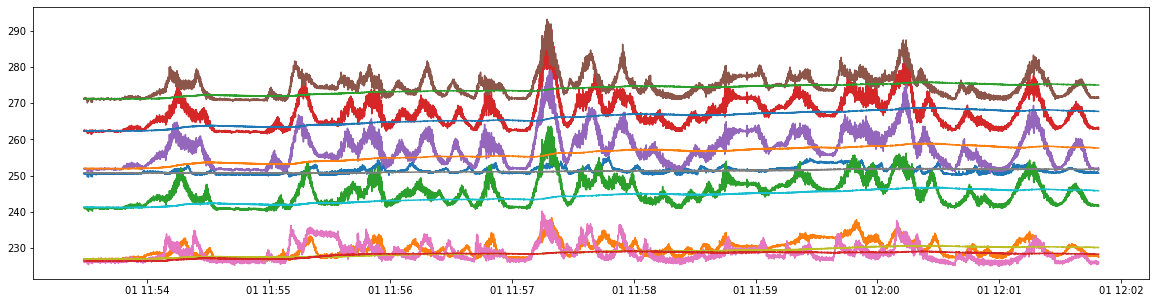

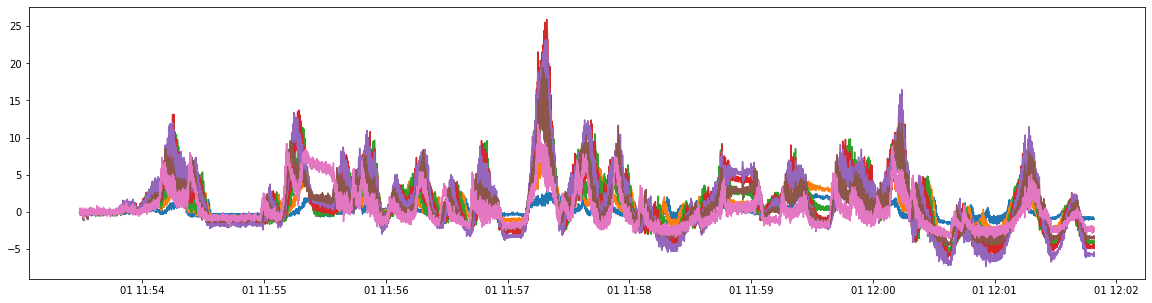

In [56]:
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(measurements)
plt.plot(filtered_data)
plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()

## Try proximity rule through A matrix

In [78]:
a_matrix = \
    np.array(
        [
            np.array([0.99, 0.01, 0, 0, 0, 0, 0]),
            np.array([0.01, 0.98, 0.01, 0, 0, 0, 0]),
            np.array([0, 0.01, 0.98, 0.01, 0, 0, 0]),
            np.array([0, 0, 0.01, 0.98, 0.01, 0, 0]),
            np.array([0, 0, 0, 0.01, 0.98, 0.01, 0]),
            np.array([0, 0, 0, 0, 0.01, 0.98, 0.01]),
            np.array([0, 0, 0, 0, 0, 0.01, 0.99])
        ]
        )

In [81]:
start = 990000
stop = 1000000

measurements = BCN_signals[~BCN_signals.index.duplicated(keep='first')].iloc[start:stop]
inputs = delta_bottom_temperature_data[~delta_bottom_temperature_data.index.duplicated(keep='first')].iloc[start:stop]

process_variance =  1e-4 * np.eye(BCN_signals.shape[1])
estimated_measurement_variance = 10000 * np.eye(BCN_signals.shape[1])

kf = \
    KalmanFilter(
        process_variance,
        estimated_measurement_variance,
        measurements.iloc[0].values,
        np.eye(BCN_signals.shape[1]),
        a_matrix = a_matrix,
        c_matrix = a_matrix
    )
compensated_data = kf.apply_filter(measurements, inputs)
filtered_data = kf.filtered_data

c:\users\max\documents\owi_lab\code\packages\dw_events\dw_events\dw_events\temperature_compensation\kalman_filter.py:145: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if self.a_matrix != (measurements_data.shape[1], measurements_data.shape[1]):


KeyError: 'SCB_ALM_BCN_FBG_HOR002_0_nr1'

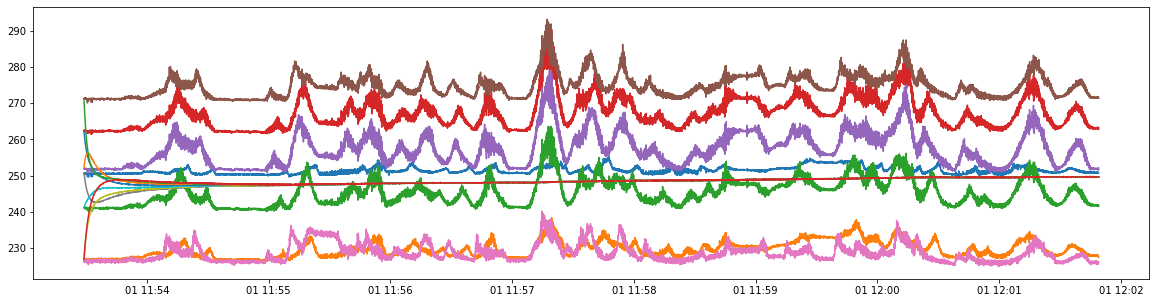

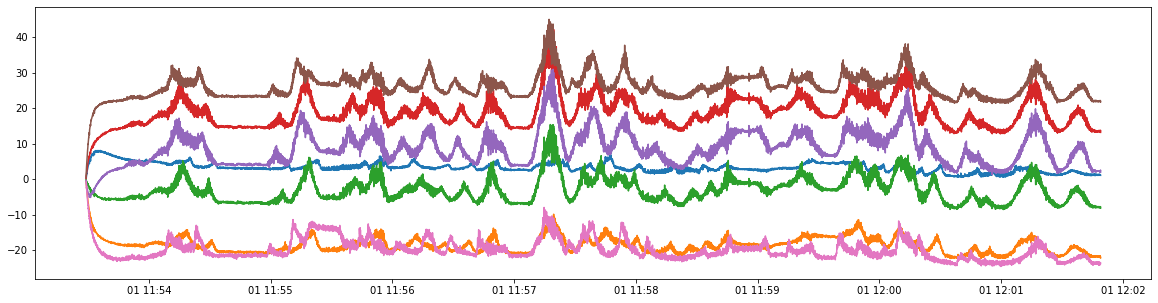

In [80]:
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(measurements)
plt.plot(filtered_data)
plt.show()
# Plot the combined portfolio
plt.figure(figsize=(20,5))
plt.plot(compensated_data)
plt.show()